# Import packages

In [1]:
!pip install optuna
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import shap
from sklearn.model_selection import TimeSeriesSplit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.7 MB/s eta 0:00:00


### Import data


In [2]:
# import data
df = pd.read_csv("/content/customer_shopping_data.csv" ,date_parser =  "invoice_date")
df.head()

/tmp/ipython-input-1074969196.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("/content/customer_shopping_data.csv" ,date_parser =  "invoice_date")


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Set invoice_date at index datetime datatype

In [3]:
# choose the time_date to be the sort by datetime
df["date"] = pd.to_datetime(df["invoice_date"], format = "%d/%m/%Y")
df = df.drop("invoice_date",axis = 1)
# sort by date
df = df.set_index("date").sort_index(ascending = True)



### Group all the same item,store in a same date

# Step 1: Preprocessing

In [4]:
df.head(15)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,shopping_mall
date,,,,,,,,,
2021-01-01,I192911,C642829,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity
2021-01-01,I313757,C438201,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul
2021-01-01,I836951,C382440,Male,54,Clothing,3,900.24,Cash,Metrocity
2021-01-01,I159235,C312481,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul
2021-01-01,I115941,C105769,Male,34,Clothing,1,300.08,Cash,Istinye Park
2021-01-01,I184824,C305423,Male,58,Shoes,3,1800.51,Credit Card,Kanyon
2021-01-01,I182802,C286477,Male,32,Clothing,5,1500.40,Cash,Mall of Istanbul
2021-01-01,I382797,C759842,Male,54,Souvenir,2,23.46,Cash,Emaar Square Mall
2021-01-01,I132894,C217270,Female,62,Food & Beverage,4,20.92,Credit Card,Viaport Outlet


### Check missing data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99457 entries, 2021-01-01 to 2023-03-08
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 7.6+ MB


In [6]:
df.isna().any()

,0
invoice_no,False
customer_id,False
gender,False
age,False
category,False
quantity,False
price,False
payment_method,False
shopping_mall,False


### Check duplicated invoice_no and customer_id

In [7]:
# check if we have duplicated invoice_id
print(len(df["invoice_no"].unique()))
print(len(df["customer_id"].unique()))
# delete the invoice_no
df = df.drop(["invoice_no","customer_id"],axis = 1)

99457
99457


### Check for outliers

In [8]:
df.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


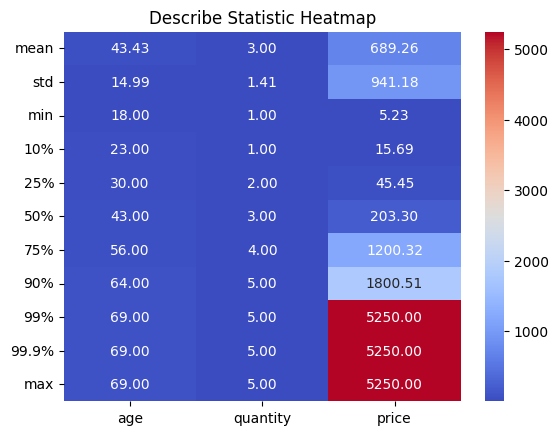

In [9]:
percentiles = df.describe(percentiles = [0.1,0.25,0.5,0.75,0.9,0.99,0.999]).iloc[1:]
sns.heatmap(percentiles, cmap = "coolwarm",annot = True, fmt = ".2f")
plt.title("Describe Statistic Heatmap")
plt.show()

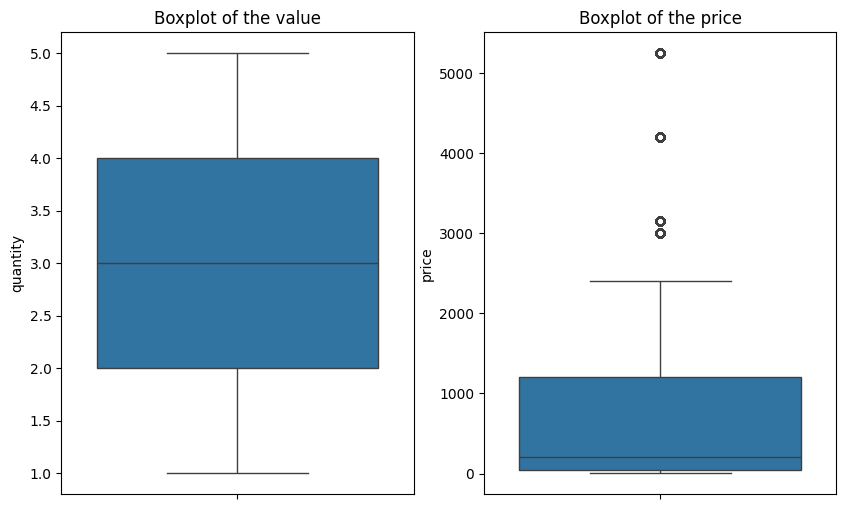

In [10]:
fig, axes = plt.subplots(1,2,figsize = (10,6))
sns.boxplot(y = df["quantity"],ax = axes[0])
sns.boxplot(y = df["price"],ax =axes[1])
axes[0].set_title("Boxplot of the value")
axes[1].set_title("Boxplot of the price")
plt.show()

### Deal with outlier

In [11]:
iqr_3 = df["price"].quantile(0.75)
iqr_1  = df["price"].quantile(0.25)
iqr = iqr_3 - iqr_1
up_limit = iqr_3 + 1.5 * iqr
outliers = df[df["price"] > up_limit]
outliers

,gender,age,category,quantity,price,payment_method,shopping_mall
date,,,,,,,
2021-01-01,Female,62,Shoes,5,3000.85,Cash,Mall of Istanbul
2021-01-01,Female,57,Technology,5,5250.00,Credit Card,Kanyon
2021-01-01,Female,34,Shoes,5,3000.85,Credit Card,Mall of Istanbul
2021-01-01,Female,33,Shoes,5,3000.85,Cash,Metrocity
2021-01-01,Female,43,Technology,4,4200.00,Cash,Zorlu Center
...,...,...,...,...,...,...,...
2023-03-08,Female,49,Technology,3,3150.00,Debit Card,Kanyon
2023-03-08,Female,62,Technology,5,5250.00,Cash,Istinye Park
2023-03-08,Male,25,Shoes,5,3000.85,Debit Card,Forum Istanbul


In [12]:
# sort outlier by category
outliers_shoes = len(outliers[outliers["category"] == "Shoes"]["price"])
print(outliers_shoes)
# check for technology
outliers_tech  = outliers[outliers["category"] == "Technology"]["price"].unique()
print(outliers_tech)

2013
[5250. 4200. 3150.]


# Step 2: EDA

### Basic statistic about sales

In [13]:
# Basic describe about sale
df["price"].describe().iloc[1:]

,price
mean,689.256321
std,941.184567
min,5.230000
25%,45.450000
50%,203.300000
75%,1200.320000
max,5250.000000


In [14]:
print(df.index.min().strftime("%Y-%m-%d"))

2021-01-01


In [15]:
# Time of the data
print(f"The sales data was collected between {df.index.min().strftime("%Y-%m-%d")} and {df.index.max().strftime("%Y-%m-%d")}")
# Check number of shopping mall and category
print(f"They are {len(df["shopping_mall"].unique())} shopping malls...")
print(f"...with {len(df["category"].unique())} categories sequentially are:")
print(df["category"].unique())

The sales data was collected between 2021-01-01 and 2023-03-08
They are 10 shopping malls...
...with 8 categories sequentially are:
['Food & Beverage' 'Clothing' 'Shoes' 'Souvenir' 'Cosmetics' 'Toys'
 'Books' 'Technology']


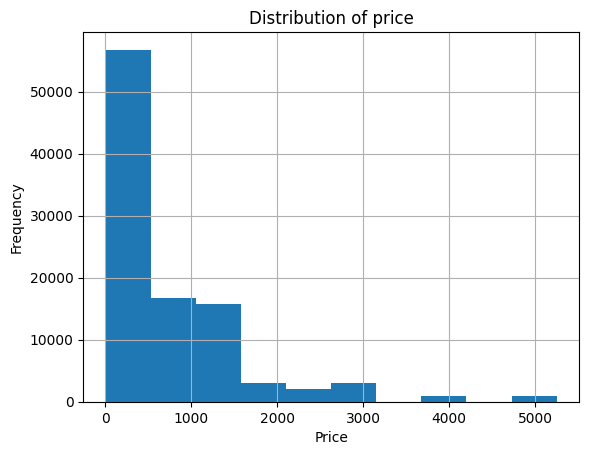

In [16]:
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of price")
df["price"].hist()
plt.show()

## Time-series sales

### Daily Sales

In [17]:
# group by daily sales
x_daily = df.index.unique()
y_daily = df["price"].groupby(df.index).sum()

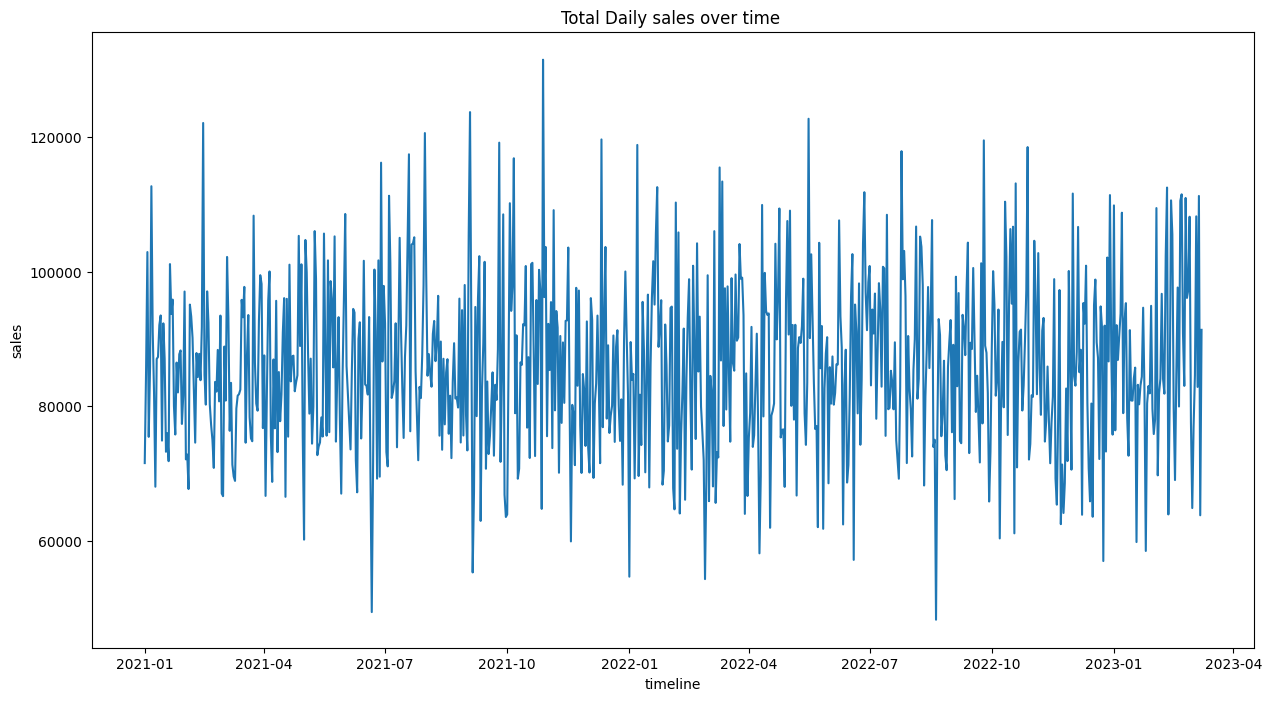

In [18]:
plt.figure(figsize = (15,8))
sns.lineplot(x = x_daily, y= y_daily)
plt.xlabel("timeline")
plt.ylabel("sales")
plt.title("Total Daily sales over time ")
plt.show()

### Day of week sales

/tmp/ipython-input-827593406.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.axhline(df["price"].groupby(df_test["weekdays"]).sum().max(),color = "red",


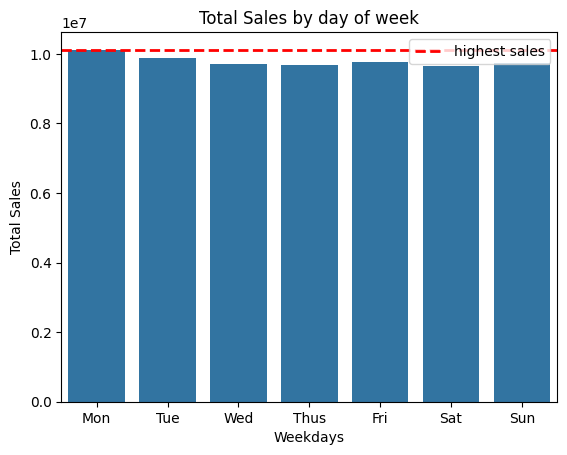

In [19]:
# Create day of week feature
df_test = df.copy()
day_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df_test["weekdays"] = df.index.day_name()
df_test["weekdays"] = pd.Categorical(df_test["weekdays"],ordered = True, categories = day_of_week)
# Create visualization

sns.barplot(x = df_test["weekdays"], y = df_test["price"],estimator = np.sum, errorbar = None)
plt.xlabel("Weekdays")
plt.ylabel("Total Sales")

plt.xticks([0,1,2,3,4,5,6],["Mon","Tue","Wed","Thus","Fri","Sat","Sun"])
plt.axhline(df["price"].groupby(df_test["weekdays"]).sum().max(),color = "red",
          linestyle = "--", label = "highest sales", linewidth = 2)
plt.legend()

plt.title("Total Sales by day of week")
plt.show()

### Total sales by category


In [20]:
top_5_category = df_test["price"].groupby(df["category"]).sum().sort_values(ascending = False).iloc[:5]

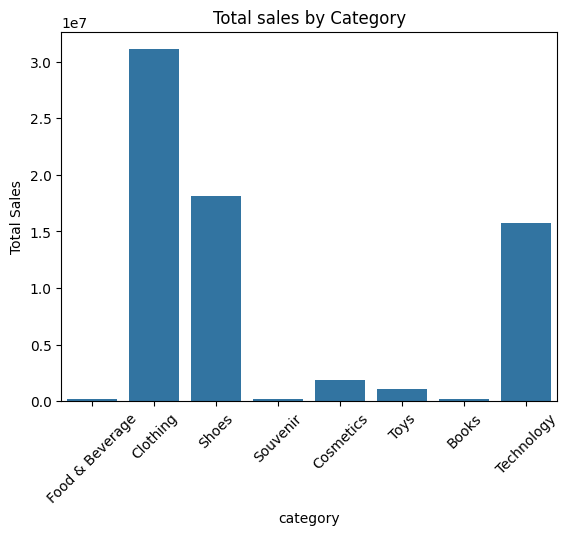

In [21]:
sns.barplot(x = df["category"], y = df["price"],estimator = np.sum,errorbar = None)
plt.xticks(rotation = 45)
plt.ylabel("Total Sales")
plt.title("Total sales by Category")
plt.show()

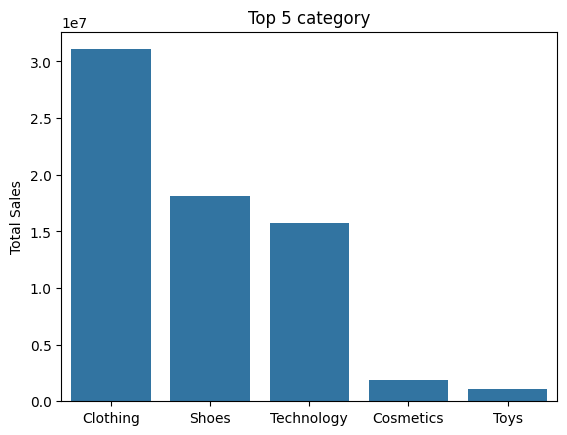

In [22]:
# only show top 5 category
sns.barplot(top_5_category,
            errorbar = None)
plt.title("Top 5 category")
plt.xlabel('')
plt.ylabel("Total Sales")
plt.show()

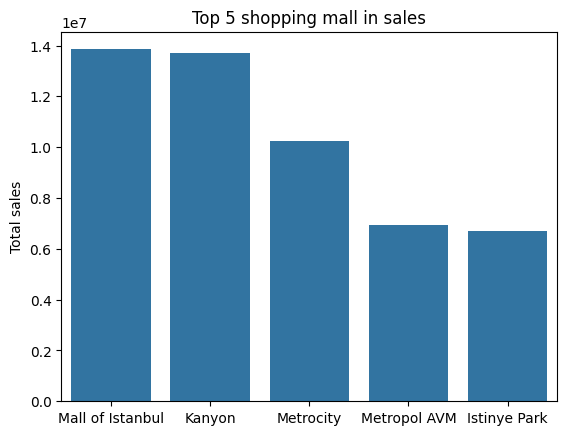

In [23]:
# Top 5 stores
sns.barplot(df.groupby("shopping_mall")["price"].sum().sort_values(
            ascending =False).iloc[:5]
            )
plt.title("Top 5 shopping mall in sales")
plt.xlabel("")
plt.ylabel("Total sales")
plt.show()

# Step 3: Feature engineering

In [24]:
df.head()

,gender,age,category,quantity,price,payment_method,shopping_mall
date,,,,,,,
2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity
2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul
2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity
2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul
2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park


### Add date data

In [25]:
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

### Add weekdays/weekends

In [26]:
df_test = df.copy()
day_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df_test["weekdays"] = df.index.day_name()
df_test["weekdays"] = pd.Categorical(df_test["weekdays"],ordered = True, categories = day_of_week)
df["weekdays"] = df_test["weekdays"]


### Holidays in Istanbull


In [27]:
holidays = []
for x in range(1,4):
  holiday = "1-1-202{}".format(x)
  holidays.append(holiday)
  holidays.append("29-3-202{}".format(x))
  holidays.append("23-4-202{}".format(x)) # national soverignty and children's day
  holidays.append("1-5-202{}".format(x)) # Labro and S
  holidays.append("19-5-202{}".format(x)) # youth & sprot day
  holidays.append("15-7-202{}".format(x)) # Democracy & national Splidarity day
  holidays.append("30-8-202{}".format(x)) # Victory day
  holidays.append("29-10-202{}".format(x)) # Republic day
holidays = pd.to_datetime(holidays, format = "%d-%m-%Y")
print(holidays)

DatetimeIndex(['2021-01-01', '2021-03-29', '2021-04-23', '2021-05-01',
               '2021-05-19', '2021-07-15', '2021-08-30', '2021-10-29',
               '2022-01-01', '2022-03-29', '2022-04-23', '2022-05-01',
               '2022-05-19', '2022-07-15', '2022-08-30', '2022-10-29',
               '2023-01-01', '2023-03-29', '2023-04-23', '2023-05-01',
               '2023-05-19', '2023-07-15', '2023-08-30', '2023-10-29'],
              dtype='datetime64[ns]', freq=None)


In [28]:
df["category"].unique()

array(['Food & Beverage', 'Clothing', 'Shoes', 'Souvenir', 'Cosmetics',
       'Toys', 'Books', 'Technology'], dtype=object)

In [29]:
# add holidays column to the data
df_test = df.copy()
df.loc[:,"holidays"] =  df_test.index.isin(holidays)
# Combine with specific days discount for special item
discount = 0.05

con1 = (df_test.index.month == 4) & (df_test.index.day == 23) & (df_test["category"].isin(["Toys","Souvenir","Books","Clothing"]))
con2 = (df_test.index.month == 5) & (df_test.index.day == 1) & (df_test["category"].isin(["Food & Beverage","Clothing","Books"]))
con3 = (df_test.index.month == 5) & (df_test.index.day == 19) & (df_test["category"].isin(["Shoes"]))
con4 = (df_test.index.month.isin([10,8])) & (df_test.index.day == 19) & (df_test["category"].isin(["Shoes"]))
con5 = (df_test.index.month == 1) & (df_test.index.day == 1) & (df_test["category"].notnull())
df_hol_dis = pd.concat([con1,con2,con3,con4,con5],axis = 1, join = "inner")
print(df_hol_dis.head())
# Apply the condition to the data
df["discount_holiday"] = df_hol_dis.any(axis = 1)
df.loc["2021-04-23",:]


            category  category  category  category  category
date                                                        
2021-01-01     False     False     False     False      True
2021-01-01     False     False     False     False      True
2021-01-01     False     False     False     False      True
2021-01-01     False     False     False     False      True
2021-01-01     False     False     False     False      True


,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,day,dayofweek,is_weekend,weekdays,holidays,discount_holiday
date,,,,,,,,,,,,,,,
2021-04-23,Female,35,Shoes,3,1800.51,Cash,Istinye Park,2021,4,23,4,0,Friday,True,False
2021-04-23,Male,38,Clothing,2,600.16,Debit Card,Emaar Square Mall,2021,4,23,4,0,Friday,True,True
2021-04-23,Male,35,Food & Beverage,5,26.15,Credit Card,Viaport Outlet,2021,4,23,4,0,Friday,True,False
2021-04-23,Female,55,Clothing,4,1200.32,Cash,Viaport Outlet,2021,4,23,4,0,Friday,True,True
2021-04-23,Female,23,Clothing,2,600.16,Cash,Zorlu Center,2021,4,23,4,0,Friday,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,Female,40,Clothing,4,1200.32,Cash,Zorlu Center,2021,4,23,4,0,Friday,True,True
2021-04-23,Male,37,Food & Beverage,3,15.69,Debit Card,Istinye Park,2021,4,23,4,0,Friday,True,False
2021-04-23,Female,25,Food & Beverage,4,20.92,Cash,Mall of Istanbul,2021,4,23,4,0,Friday,True,False


In [30]:
df.head()

,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,day,dayofweek,is_weekend,weekdays,holidays,discount_holiday
date,,,,,,,,,,,,,,,
2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,1,4,0,Friday,True,True
2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True
2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,1,4,0,Friday,True,True
2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True
2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,1,4,0,Friday,True,True


In [31]:
df_test.shape

(99457, 13)

### Dealing with categorical features

In [32]:
df_features = df.copy()

In [33]:
df_features.head()

,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,day,dayofweek,is_weekend,weekdays,holidays,discount_holiday
date,,,,,,,,,,,,,,,
2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,1,4,0,Friday,True,True
2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True
2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,1,4,0,Friday,True,True
2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True
2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,1,4,0,Friday,True,True


In [34]:
# group quantity and sales  by date, shopping_mall, category
# df_group = df_features.groupby([df.index,df["shopping_mall"],df["category"]]).transform(
#                           quantity = ("quantity","sum"), sales_total = ("price","sum"),
#                           sales_avg = ("price","mean")
    # features of gender
df_features.loc[:,"daily_female_ratio"] = df_features.groupby(
                        [df.index,df["shopping_mall"],df["category"]])["gender"]\
                          .transform(lambda x: round((x=="Female").mean(),2) * 100)
    # features of payment_method
df_features.loc[:,"creadit_ratio"] = df_features.groupby(
                        [df.index,df["shopping_mall"],df["category"]])["payment_method"]\
                          .transform(lambda x: round((x=="Credit Card").mean(),4) * 100)
df_features.loc[:,"debit_ratio"] = df_features.groupby(
                        [df.index,df["shopping_mall"],df["category"]])["payment_method"]\
                          .transform(lambda x: round((x=="Debit Card").mean(),4) * 100)

In [35]:
df_features.head()

,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,day,dayofweek,is_weekend,weekdays,holidays,discount_holiday,daily_female_ratio,creadit_ratio,debit_ratio
date,,,,,,,,,,,,,,,,,,
2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,1,4,0,Friday,True,True,100.0,50.00,0.0
2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True,62.0,25.00,12.5
2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,1,4,0,Friday,True,True,40.0,60.00,0.0
2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True,0.0,100.00,0.0
2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,1,4,0,Friday,True,True,0.0,66.67,0.0


In [36]:
# test gender group
condition = ((df_features.index == "2021-01-01") & (df_features["shopping_mall"] == "Metrocity")
            & (df_features["category"] == "Food & Beverage"))
df_features[condition]
df_features[condition]["payment_method"].value_counts()

,count
payment_method,
Credit Card,2
Cash,2


In [37]:
# test payment_method group
df_features[condition]["payment_method"].value_counts()

,count
payment_method,
Credit Card,2
Cash,2


In [38]:
df_test = df_features.copy()

In [39]:
df_test.head()

,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,day,dayofweek,is_weekend,weekdays,holidays,discount_holiday,daily_female_ratio,creadit_ratio,debit_ratio
date,,,,,,,,,,,,,,,,,,
2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,1,4,0,Friday,True,True,100.0,50.00,0.0
2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True,62.0,25.00,12.5
2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,1,4,0,Friday,True,True,40.0,60.00,0.0
2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,1,4,0,Friday,True,True,0.0,100.00,0.0
2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,1,4,0,Friday,True,True,0.0,66.67,0.0


In [40]:
for n in [7, 14, 28]:
    # Group by store_item and category create lag features
    df_features.loc[:,f"mean_sales_{n}d"] = df_features.groupby([df_features["shopping_mall"]]
                                                         )["price"].transform(
      lambda x: x.shift(1).rolling(f"{n}D", min_periods=1).mean())
     # Min of last n days
    df_features[f"sales_min_{n}d"] = df_features.groupby("shopping_mall")[
        "price"
    ].transform(lambda x: x.shift(1).rolling(f"{n}D", min_periods=1).min())
    # Max of last n days
    df_features[f"sales_max_{n}d"] = df_features.groupby("shopping_mall")[
        "price"
    ].transform(lambda x: x.shift(1).rolling(f"{n}D", min_periods=1).max())
    # Standard deviation of last n days
    df_features[f"sales_std_{n}d"] = df_features.groupby("shopping_mall")[
        "price"
    ].transform(lambda x: x.shift(1).rolling(f"{n}D", min_periods=1).std())

In [41]:
df_features.head()

,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,day,...,sales_max_7d,sales_std_7d,mean_sales_14d,sales_min_14d,sales_max_14d,sales_std_14d,mean_sales_28d,sales_min_28d,sales_max_28d,sales_std_28d
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,1,...,26.15,NaN,26.15,26.15,26.15,NaN,26.15,26.15,26.15,NaN
2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,1,...,1200.32,NaN,1200.32,1200.32,1200.32,NaN,1200.32,1200.32,1200.32,NaN
2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exponentially weighted moving average

In [42]:
# Exponentially weighted moving average
for alpha in [0.5, 0.75]:
    for window in [7, 14, 28]:
        # Create an EWMA feature
        alpha_str = str(alpha).replace(".", "")
        df_features[f"sales_ewma_{window}d_a{alpha_str}"] = df_features.groupby(
            ["shopping_mall","category"]
        )["price"].transform(lambda x: x.shift(1).ewm(alpha=alpha).mean())




### Shopping mall-level features

In [43]:

print(df_features.shape)


(99457, 36)


In [44]:
df_features = df_features.copy().reset_index()
bins = pd.date_range("2021-01-01 ",df_features["date"].max(), freq ="7D")
start_mall = df_features["date"].min()
for bin in bins[1:]:
  for mall in df_features["shopping_mall"].unique():
    condition = (df_features["date"] >= start_mall) & (df_features["date"] < bin) & (df_features["shopping_mall"] == f"{mall}")

    sum_mall = df_features[condition]["price"].sum()
    mean_mall = df_features[condition]['price'].mean()
    df_features.loc[condition,"mall_sum_7_d"] = sum_mall
    df_features.loc[condition,"mall_mean_7_d"] = mean_mall
  # add bin for last value, so doens't fill
  start_mall = bin
l_con = df_features["date"] >= start_mall
df_features.loc[l_con,"mall_sum_7_d"] = df_features[l_con].groupby(["shopping_mall","date"])[
    "price"].transform("sum")
df_features.loc[l_con,"mall_mean_7_d"] = df_features[l_con].groupby(["shopping_mall","date"])[
    "price"].transform("mean")



In [45]:
df_features.head()

,date,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,...,sales_max_28d,sales_std_28d,sales_ewma_7d_a05,sales_ewma_14d_a05,sales_ewma_28d_a05,sales_ewma_7d_a075,sales_ewma_14d_a075,sales_ewma_28d_a075,mall_sum_7_d,mall_mean_7_d
0,2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78823.56,620.657953
1,2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185458.60,976.097895
2,2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,...,26.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78823.56,620.657953
3,2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,...,1200.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185458.60,976.097895
4,2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52878.95,568.590860


In [46]:
df_features.head(10)

,date,gender,age,category,quantity,price,payment_method,shopping_mall,year,month,...,sales_max_28d,sales_std_28d,sales_ewma_7d_a05,sales_ewma_14d_a05,sales_ewma_28d_a05,sales_ewma_7d_a075,sales_ewma_14d_a075,sales_ewma_28d_a075,mall_sum_7_d,mall_mean_7_d
0,2021-01-01,Female,66,Food & Beverage,5,26.15,Credit Card,Metrocity,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78823.56,620.657953
1,2021-01-01,Female,43,Clothing,4,1200.32,Credit Card,Mall of Istanbul,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185458.60,976.097895
2,2021-01-01,Male,54,Clothing,3,900.24,Cash,Metrocity,2021,1,...,26.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78823.56,620.657953
3,2021-01-01,Male,58,Food & Beverage,4,20.92,Credit Card,Mall of Istanbul,2021,1,...,1200.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185458.60,976.097895
4,2021-01-01,Male,34,Clothing,1,300.08,Cash,Istinye Park,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52878.95,568.590860
5,2021-01-01,Male,58,Shoes,3,1800.51,Credit Card,Kanyon,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130223.81,723.465611
6,2021-01-01,Male,32,Clothing,5,1500.40,Cash,Mall of Istanbul,2021,1,...,1200.32,833.961738,1200.32,1200.32,1200.32,1200.32,1200.32,1200.32,185458.60,976.097895
7,2021-01-01,Male,54,Souvenir,2,23.46,Cash,Emaar Square Mall,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23668.94,577.291220
8,2021-01-01,Female,62,Food & Beverage,4,20.92,Credit Card,Viaport Outlet,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19979.03,434.326739
9,2021-01-01,Male,21,Clothing,3,900.24,Cash,Cevahir AVM,2021,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25915.89,508.154706


### Item-level features

In [47]:
df_test["category"].unique()

array(['Food & Beverage', 'Clothing', 'Shoes', 'Souvenir', 'Cosmetics',
       'Toys', 'Books', 'Technology'], dtype=object)

In [48]:
start_item = df_features["date"].min()
for bin in bins[1:]:
  for item in df_test["category"].unique():
    condition = (df_features["date"] >= start_item) & (df_features["date"] < bin) & (df_features["category"] == f"{item}")

    sum_item = df_features[condition]["price"].sum()
    mean_item = df_features[condition]['price'].mean()
    df_features.loc[condition,"item_sum_7_d"] = sum_item
    df_features.loc[condition,"item_mean_7_d"] = mean_item
  # add bin for last value, so doens't fill
  start_item = bin
l_con = df_features["date"] >= start_item
df_features.loc[l_con,"item_sum_7_d"] = df_features[l_con].groupby(["category"])[
    "price"].transform("sum")
df_features.loc[l_con,"item_mean_7_d"] = df_features[l_con].groupby(["category"])[
    "price"].transform("mean")

### Change object column into categorical data

In [49]:
df_features["category"] = df_features["category"] .astype("category")
df_features["shopping_mall"] = df_features["shopping_mall"] .astype("category")

In [50]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 99457 non-null  datetime64[ns]
 1   gender               99457 non-null  object        
 2   age                  99457 non-null  int64         
 3   category             99457 non-null  category      
 4   quantity             99457 non-null  int64         
 5   price                99457 non-null  float64       
 6   payment_method       99457 non-null  object        
 7   shopping_mall        99457 non-null  category      
 8   year                 99457 non-null  int32         
 9   month                99457 non-null  int32         
 10  day                  99457 non-null  int32         
 11  dayofweek            99457 non-null  int32         
 12  is_weekend           99457 non-null  int64         
 13  weekdays             99457 non-

# Step 4: Train model

### Split train, validation and test data  

In [51]:
df_features[["dayofweek","weekdays","is_weekend"]].value_counts()

,,,count
dayofweek,weekdays,is_weekend,
0,Monday,0,14383
4,Friday,0,14347
1,Tuesday,0,14217
6,Sunday,1,14140
3,Thursday,0,14129
5,Saturday,1,14121
2,Wednesday,0,14120


In [52]:
df_features.columns

Index(['date', 'gender', 'age', 'category', 'quantity', 'price',
       'payment_method', 'shopping_mall', 'year', 'month', 'day', 'dayofweek',
       'is_weekend', 'weekdays', 'holidays', 'discount_holiday',
       'daily_female_ratio', 'creadit_ratio', 'debit_ratio', 'mean_sales_7d',
       'sales_min_7d', 'sales_max_7d', 'sales_std_7d', 'mean_sales_14d',
       'sales_min_14d', 'sales_max_14d', 'sales_std_14d', 'mean_sales_28d',
       'sales_min_28d', 'sales_max_28d', 'sales_std_28d', 'sales_ewma_7d_a05',
       'sales_ewma_14d_a05', 'sales_ewma_28d_a05', 'sales_ewma_7d_a075',
       'sales_ewma_14d_a075', 'sales_ewma_28d_a075', 'mall_sum_7_d',
       'mall_mean_7_d', 'item_sum_7_d', 'item_mean_7_d'],
      dtype='object')

In [53]:
# Test set will be the last 3 months of 2023 (Jan, Feb, Mar 2023)
cutoff_date = pd.Timestamp("2023-01-01")
print(f"Train-test split date: {cutoff_date}")

# Create a flag for train/test split
df_features["is_test"] = df_features["date"] >= cutoff_date
print(f"Training df_features: {len(df_features[~df_features['is_test']])} rows")
print(f"Test df_features: {len(df_features[df_features['is_test']])} rows")

Train-test split date: 2023-01-01 00:00:00
Training df_features: 90933 rows
Test df_features: 8524 rows


In [54]:
# Drop unnecessary columns for modeling
cols_to_drop = [
    "date",
    "gender",
    "payment_method",
    "weekdays",
    "is_test",

]

# Split features and target, and separate train/test
X_train = df_features[~df_features["is_test"]].drop(cols_to_drop + ["price"], axis=1)
y_train = df_features[~df_features["is_test"]]["price"]

X_test = df_features[df_features["is_test"]].drop(cols_to_drop + ["price"], axis=1)
y_test = df_features[df_features["is_test"]]["price"]





## Builg LightGBM model

In [55]:
# Basic LightGBM parameters
def create_lightgbm_model(X_train, y_train, X_test, y_test):
    """
    Create a LightGBM model using engineered features
    """
    print("\nCreating base lightgbm model...")

    # Use a time series split for validation within the training set
    # This ensures we're always validating on future data
    tscv = TimeSeriesSplit(n_splits=5)
    params = {
        "boosting_type": "gbdt", "num_leaves": 28, "learning_rate": 0.05,
        "max_depth": 10, "n_estimators": 400, "objective": "regression",
        "min_child_samples": 40,
        "feature_fraction": 0.75,
        "categorical_feature": ["shopping_mall","category"],
        "verbose": -1,"save_binary": True
    }
    cv_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            callbacks=[lgb.early_stopping(stopping_rounds= 25)]
        )

        # Make predictions
        preds = model.predict(X_val_cv)

        # Calculate metrics
        mae = mean_absolute_error(y_val_cv, preds)
        rmse = np.sqrt(mean_squared_error(y_val_cv, preds))


        cv_scores.append((mae, rmse, ))

    # Print average scores from cross-validation
    mae_avg, rmse_avg,  = np.mean(cv_scores, axis=0)
    print(
        f"Baseline Model CV - MAE: {mae_avg:.2f}, RMSE: {rmse_avg:.2f}"
    )

    # Train a final model on all training data
    final_model = lgb.LGBMRegressor(**params)
    final_model.fit(X_train, y_train)

    # Evaluate on the test set (last 3 months of 2017)
    test_preds = final_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    print(
        f"Baseline Model Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}"
    )

    return final_model, (mae_avg, rmse_avg), (test_mae, test_rmse)

In [56]:
lightgbm_model,lightsgbm_baseline, lightgbm_metrics = create_lightgbm_model(
    X_train, y_train, X_test, y_test
)


Creating base lightgbm model...


/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 416.136


/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 291.047


/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 98.3574


/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 77.5151


/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 64.6618
Baseline Model CV - MAE: 3.41, RMSE: 12.84


/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.12/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


Baseline Model Test - MAE: 1.85, RMSE: 6.72


In [57]:
print(lightgbm_metrics)

(1.8452580343445257, np.float64(6.720227717018615))


## Using Optuna for Optimization

In [58]:
def optimize_lightgbm(X_train, y_train, X_test, y_test):
    """
    Optimize LightGBM model using Optuna
    """

    print("\nOptimizing LightGBM model with Optuna...")

    def objective(trial):
        """Optuna objective function for LightGBM optimization"""
        params = {
            "objective": "regression",
            "metric": "rmse",
            "boosting_type": "gbdt",
            "categorical_feature": ["shopping_mall","category"],
            "num_leaves": trial.suggest_int("num_leaves",5,50),
            "max_depth": trial.suggest_int("max_depth", 5,40),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1,5,15),
            "min_child_samples": trial.suggest_int("min_child_samples", 5,50),
            "n_estimators": 1000,
            "verbose": -1,
        }

        # Train with early stopping
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[lgb.early_stopping(stopping_rounds=50)],
        )

        # Predict and calculate RMSE
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        return rmse

    # Create and run study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)  # In practice, use more trials

    # Get best parameters
    best_params = study.best_params
    best_params.update(
        {
            "objective": "regression",
            "metric": "rmse",
            "boosting_type": "gbdt",
            "verbose": -1
        }
    )

    print("Best LightGBM parameters found:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")

    # Train final model with best parameters
    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions
    test_preds = final_model.predict(X_test)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    print(
        f"Optimized LightGBM Test Metrics - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}"
    )

    return final_model, test_preds, (test_mae, test_rmse)


In [59]:
# optimized_model, best_params, optimized_metrics = optimize_lightgbm(
#     X_train, y_train, X_test, y_test
# )

In [60]:
# Trial 199 finished with value: 0.5122880793231175 and parameters: {'num_leaves': 14, 'max_depth': 22, 'learning_rate': 0.06617453884193888, 'feature_fraction': 0.9843205123391826, 'bagging_fraction': 0.9994705954988784, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 132 with value: 0.02030539730030443.

# Best LightGBM parameters found:
#     num_leaves: 11
#     max_depth: 19
#     learning_rate: 0.06291492832051511
#     feature_fraction: 0.9995335580156063
#     bagging_fraction: 0.9908182236013517
#     bagging_freq: 1
#     min_child_samples: 22
#     objective: regression
#     metric: rmse
#     boosting_type: gbdt
#     verbose: -1
# Optimized LightGBM Test Metrics - MAE: 2.03, RMSE: 2.79
# Baseline Model Test - MAE: 1.85, RMSE: 6.72

In [61]:
best_params = {
            "num_leaves": 11,
            "max_depth": 19,
            "learning_rate": 0.06291492832051511,
            "feature_fraction": 0.9995335580156063,
            "bagging_fraction": 0.9908182236013517,
            "bagging_freq": 1,
            "min_child_samples": 22,
            "objective": "regression",
            "boosting_type": "gbdt",
            "verbose": -1
        }
best_model = lgb.LGBMRegressor()
best_model.fit(
            X_train,
            y_train)

LGBMRegressor()

## Evaluate Model


In [62]:
def evaluate_model(model, X_test, y_test, data):
    """
    Evaluate the model performance on the test set (last 3 months of 2017)
    """
    print("\nEvaluating model performance on test set...")

    # Make predictions on the test set
    test_preds = model.predict(X_test)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))


    # Print evaluation results
    print(f"Final Model Test Evaluation:")
    print(f"    MAE: {test_mae:.2f}")
    print(f"    RMSE: {test_rmse:.2f}")


    # Analyze errors by time period (month)
    test_results = data[data["is_test"]].copy()
    test_results["prediction"] = test_preds
    test_results["error"] = test_results["price"] - test_results["prediction"]
    test_results["abs_error"] = np.abs(test_results["error"])
    test_results["month_name"] = test_results["date"].dt.strftime("%B")

    # Summarize errors by month
    monthly_errors = (
        test_results.groupby("month_name")
        .agg({"abs_error": "mean", "error": "mean", "price": "mean"})
        .reset_index()
    )
    monthly_errors["error_pct"] = (
        100 * monthly_errors["abs_error"] / monthly_errors["price"]
    )

    print("\nError Analysis by Month:")
    print(
        monthly_errors[["month_name", "abs_error", "error_pct"]].to_string(index=False)
    )

    # Store results for visualization
    # Include month and store information for granular analysis
    test_results["year_month"] = test_results["date"].dt.strftime("%Y-%m")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
    plt.title("Actual vs Predicted Sales (Test Set)")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.tight_layout()
    # plt.savefig('actual_vs_predicted_test.png')

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(test_results["error"], kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.tight_layout()
    # plt.savefig('error_distribution.png')

    return test_mae, test_rmse, test_preds, y_test, test_results


Evaluating model performance on test set...
Final Model Test Evaluation:
    MAE: 0.05
    RMSE: 0.17

Error Analysis by Month:
month_name  abs_error  error_pct
  February   0.055067   0.007809
   January   0.039841   0.005970
     March   0.035816   0.005081


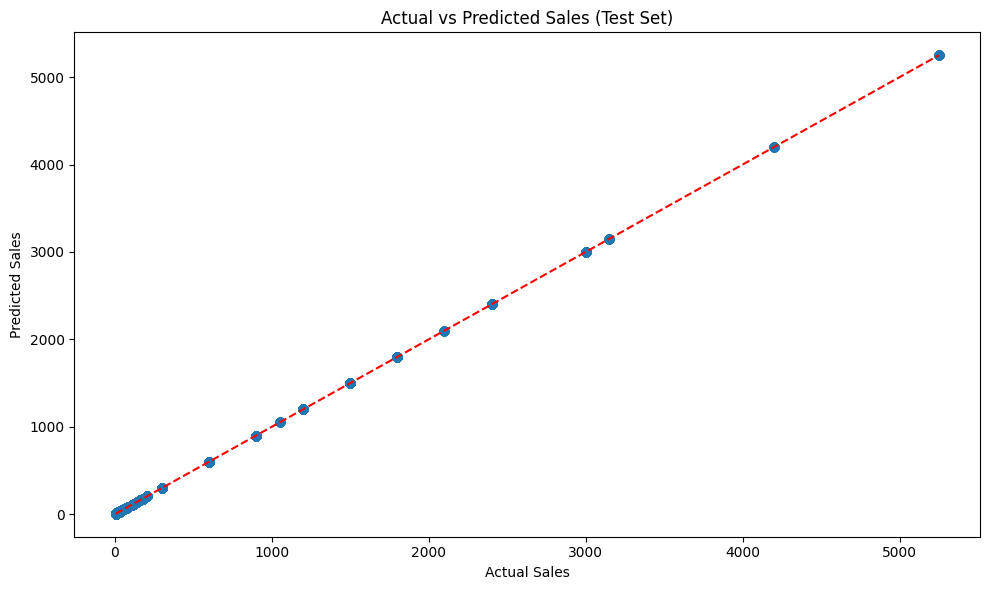

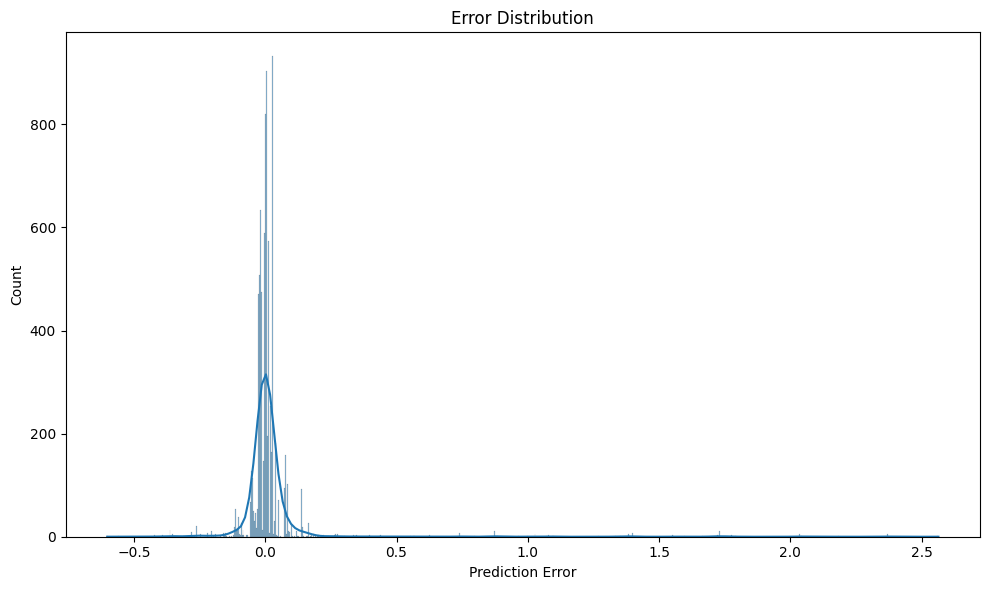

In [63]:
# Evaluate the lightgbm model
test_mae, test_rmse, test_preds, y_test_values, test_results = (
    evaluate_model(best_model, X_test, y_test, df_features)
)


# Step 5: XAI

In [65]:
# Using the best_model above to test data
test_results = df_features[df_features["is_test"]].copy()
test_results["prediction"] = best_model.predict(X_test)
test_results["error"] = test_results["price"] - test_results["prediction"]
test_results["abs_error"] = np.abs(test_results["error"])
df_prediction = test_results[
    ["date", "shopping_mall", "category", "price", "prediction"]
]


### showing features importance

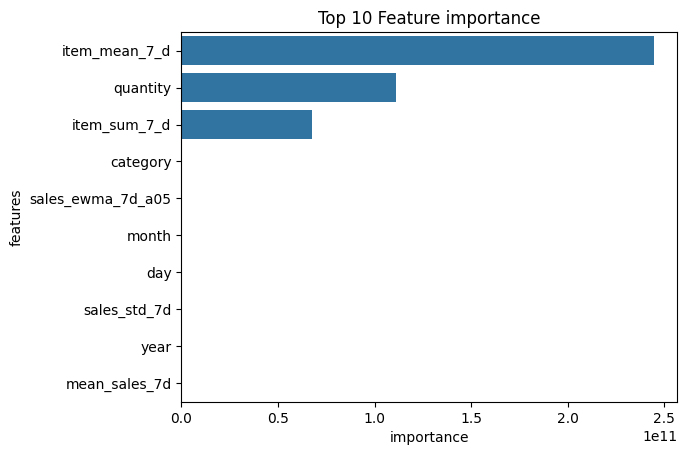

In [84]:
f_name = best_model.feature_name_
f_imp = best_model.booster_.feature_importance(importance_type='gain')
df_fi = pd.DataFrame({"features":f_name,"importance":f_imp}).\
          sort_values(by = "importance",ascending = False)
sns.barplot(x = "importance",data = df_fi.head(10),y = "features")
plt.title("Top 10 Feature importance")
plt.show()


- We have three features importance here are ***item_mean_7_d***, ***quantiy*** and ***item_sum_7_d***. Now we try using **SHAP** to see if this is true

### Calculate SHAP

In [66]:
# Use samples from both training and test sets
X_train_sample = X_train.sample(min(500, len(X_train)), random_state=42)
X_test_sample = X_test.sample(min(500, len(X_test)), random_state=42)
X_sample = pd.concat([X_train_sample, X_test_sample])

In [67]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)



In [68]:
pd.DataFrame(shap_values, columns=X_sample.columns)

,age,category,quantity,shopping_mall,year,month,day,dayofweek,is_weekend,holidays,...,sales_ewma_7d_a05,sales_ewma_14d_a05,sales_ewma_28d_a05,sales_ewma_7d_a075,sales_ewma_14d_a075,sales_ewma_28d_a075,mall_sum_7_d,mall_mean_7_d,item_sum_7_d,item_mean_7_d
0,0.0,-0.727926,268.324264,0.0,0.000130,0.040784,-0.001019,0.0,0.0,0.0,...,0.041144,0.0,0.0,-0.001134,0.0,0.0,0.0,-0.000031,-413.766184,-363.998103
1,0.0,0.402084,-251.609094,0.0,0.000314,0.024615,0.001242,0.0,0.0,0.0,...,0.132632,0.0,0.0,-0.000660,0.0,0.0,0.0,-0.000007,-209.582393,-213.466029
2,0.0,-0.389989,-525.083569,0.0,0.000027,0.045584,0.000159,0.0,0.0,0.0,...,0.019478,0.0,0.0,-0.000333,0.0,0.0,0.0,-0.000004,292.241807,-156.134582
3,0.0,-0.431894,-263.302893,0.0,-0.000030,0.045820,0.000172,0.0,0.0,0.0,...,0.018812,0.0,0.0,-0.000479,0.0,0.0,0.0,-0.000004,367.055399,-192.623720
4,0.0,-0.275300,133.625382,0.0,-0.000182,-0.081728,0.003286,0.0,0.0,0.0,...,0.058194,0.0,0.0,-0.001134,0.0,0.0,0.0,-0.000007,-361.110626,-318.285416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,-3.040445,-122.029156,0.0,0.000071,-0.016616,-0.001322,0.0,0.0,0.0,...,-0.072596,0.0,0.0,0.002812,0.0,0.0,0.0,-0.000004,-268.879285,-284.904491
996,0.0,-0.362153,-401.757238,0.0,0.000019,-0.018547,0.000195,0.0,0.0,0.0,...,0.034901,0.0,0.0,-0.000479,0.0,0.0,0.0,-0.000007,-127.768566,1040.803757
997,0.0,-0.556402,522.059662,0.0,0.000054,0.074320,-0.000399,0.0,0.0,0.0,...,0.023653,0.0,0.0,-0.000520,0.0,0.0,0.0,0.000050,591.590252,-302.217869
998,0.0,-2.110301,-243.417451,0.0,0.000071,-0.013804,-0.000313,0.0,0.0,0.0,...,-0.122304,0.0,0.0,0.000910,0.0,0.0,0.0,-0.000004,-212.729149,-225.726897


### Global feature importance

Top 10 most important features globally:
           feature  importance
     item_mean_7_d  469.411017
      item_sum_7_d  336.992906
          quantity  261.886062
          category    1.440364
 sales_ewma_7d_a05    0.068446
             month    0.042037
sales_ewma_7d_a075    0.001301
               day    0.001121
     mean_sales_7d    0.001037
      sales_std_7d    0.000852


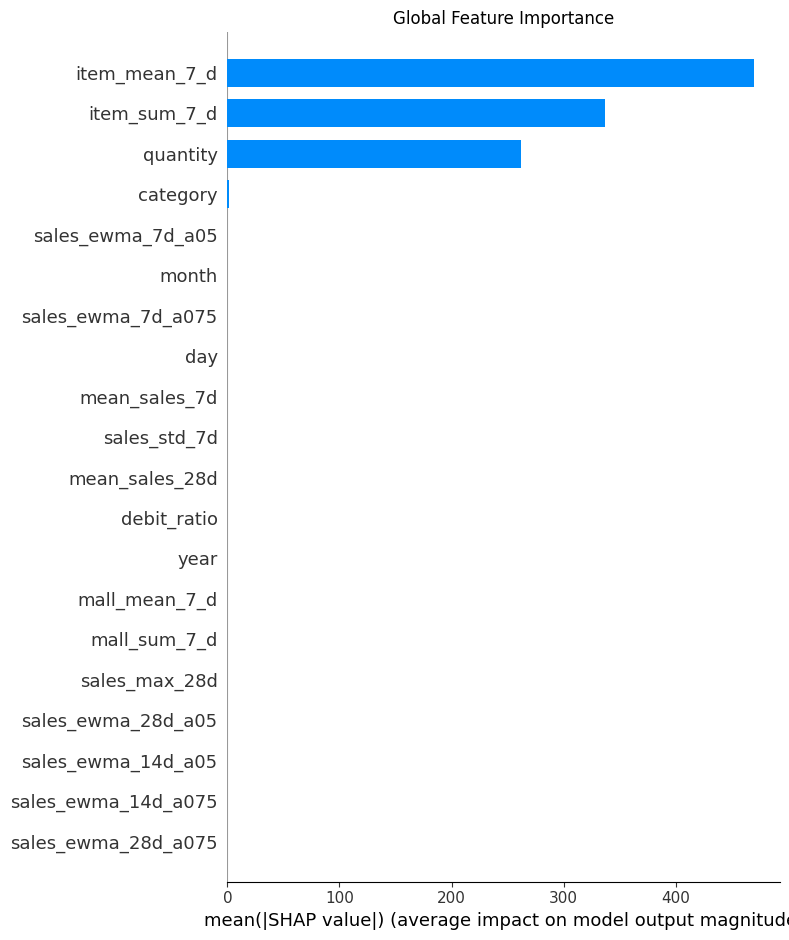

In [69]:
# Global feature importance
print("Top 10 most important features globally:")
feature_importance = pd.DataFrame(
    {"feature": X_sample.columns, "importance": np.abs(shap_values).mean(axis=0)}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
print(feature_importance.head(10).to_string(index=False))

# Global feature importance plot
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.tight_layout()


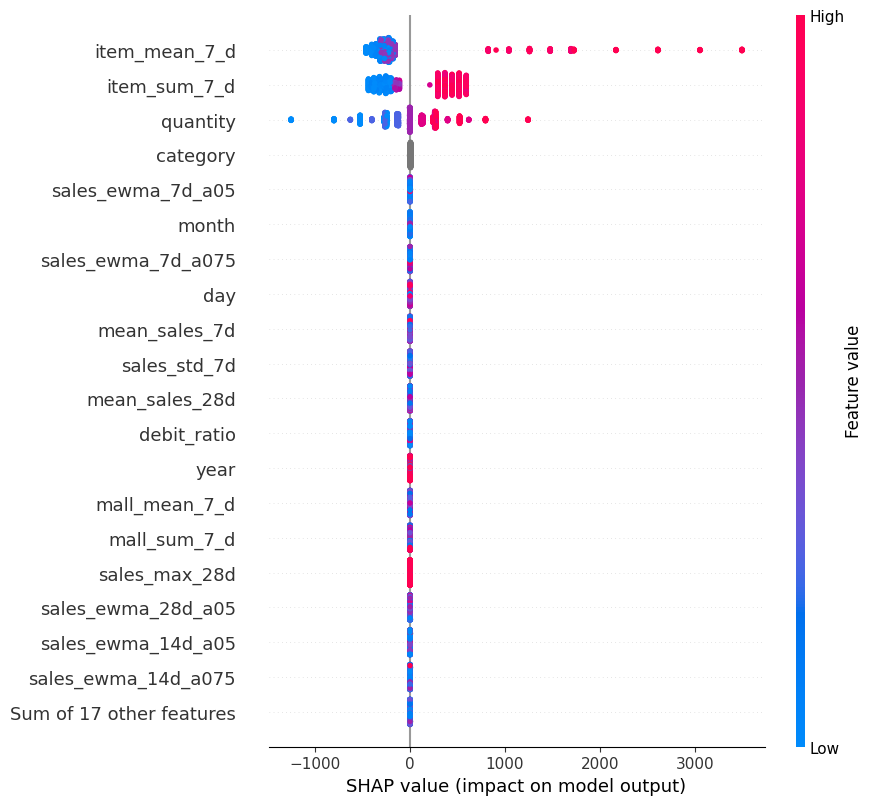

In [70]:
# Summarize the effects of all the features
shap.plots.beeswarm(explainer(X_sample), max_display=20)

- **Top most features**
  - **item_mean_7d**: the average sales of the product over the past 7 days. A product that has sold well recently (7 days) is an strong sign for predicting high sales.
  - **item_sum_7d**: the sum of sales of the product over the past 7 days also have an optimistic impact on the furture sales. And it seem's more stable than the **item_mean_7d** because it's not been effected by very high items.
  - **quantity**: The quantity of product show that if the higher quantity that the customers bought, the stronger the signal we have so we can trust our prediction  

- Compare with feature importance by *"gain"* in LightGBM
We see that **SHAP** also have the same result at LightGBM when choose the feature_importance, so it increase out understand and trust in explanation

- **Key Observation**
  - The model is highly sensitive to recent sales trends (averages, totals, standard deviations).
  - Features **item_mean_7d** and **item_sum_7d** have the strongest influence on the model's decisions.
  


In [71]:
shap_values_valid = explainer(X_sample)


In [86]:
# SHAP dependency plots for top features
feature_name = "item_mean_7d"
shap.plots.scatter(shap_values[:, "item_mean_7d"])



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Group Features importance

In [87]:
X_sample.columns

Index(['age', 'category', 'quantity', 'shopping_mall', 'year', 'month', 'day',
       'dayofweek', 'is_weekend', 'holidays', 'discount_holiday',
       'daily_female_ratio', 'creadit_ratio', 'debit_ratio', 'mean_sales_7d',
       'sales_min_7d', 'sales_max_7d', 'sales_std_7d', 'mean_sales_14d',
       'sales_min_14d', 'sales_max_14d', 'sales_std_14d', 'mean_sales_28d',
       'sales_min_28d', 'sales_max_28d', 'sales_std_28d', 'sales_ewma_7d_a05',
       'sales_ewma_14d_a05', 'sales_ewma_28d_a05', 'sales_ewma_7d_a075',
       'sales_ewma_14d_a075', 'sales_ewma_28d_a075', 'mall_sum_7_d',
       'mall_mean_7_d', 'item_sum_7_d', 'item_mean_7_d'],
      dtype='object')

In [88]:
df_shap = pd.DataFrame(shap_values,columns = X_sample.columns)

In [108]:

# group category
datetime = ["year","day","month","is_weekend","holidays","dayofweek","discount_holiday"]

sales_history = X_sample.columns[(X_sample.columns.str.startswith("sales_")) +
                                 (X_sample.columns.str.startswith("mean_"))].tolist()
categories = ["category","item_sum_7_d","item_mean_7_d"]
stores = ["shopping_mall","mall_sum_7_d","mall_mean_7_d"]
quantity = ["quantity"]
others = X_sample.columns[~X_sample.columns.isin(dt+ sales_history + categories + stores + quantity)]
print(others)
groups = [dt,sales_history,categories, stores,others]



Index(['age', 'daily_female_ratio', 'creadit_ratio', 'debit_ratio'], dtype='object')


In [143]:
name_gr = ["datetime","sales_history", "categories","stores","quantity","others"]
shap_gr = []
total = 0
for g in [datetime,sales_history, categories,stores,quantity, others]:
    val_gr = round(df_shap[g].apply(lambda x: np.abs(x).sum(axis = 0)).sum(),3)
    shap_gr.append(val_gr)
    total += val_gr
print(shap_gr)
print(total)
pct_gr = shap_gr / total * 100
for i in pct_gr:
  print(round(i,3))

[np.float64(43.29), np.float64(72.479), np.float64(807844.287), np.float64(0.015), np.float64(261886.062), np.float64(0.158)]
1069846.291
0.004
0.007
75.51
0.0
24.479
0.0


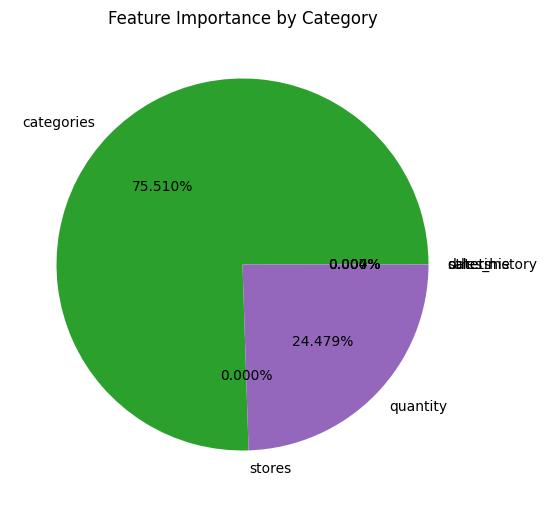

In [133]:
plt.figure(figsize=(6, 12))
plt.pie(pct_gr, labels=name_gr, autopct="%1.3f%%")
plt.title("Feature Importance by Category")
# plt.tight_layout()
plt.show()

|Group_feautre|Importance_proportion|Meaning
|---|---|---|
|Categories|75.51%|**item_mean_7_d**, *item_sum_7_d*,"category" are the features are the most importance|
|Quantity|24.479%|**quantity** are the second most importance feature
|Datetime|0.04%|features like **year,day, month,is_weekend, holidays, dayofweek, discount_holiday**
|Sales_history|0.07%|Includes features based on historical sales (rolling mean, std, lag), which have **negligible impact**|
|Other|0%|those features: **age, daily_female_ratio, creadit_ratio, debit_ratio** does't have any effect in final predicting|


## Business insight


### **1. Product Categories Drive the Majority of Sales Prediction Power (75.51%)**

- Different product categories have **distinct demand patterns**.

- Category-level behavior is the strongest driver of sales.

- Improving category-level strategies (pricing, promotion, stocking) will likely generate the **largest ROI**.

- It suggests that customers decide mainly based on **what type of item** it is—not time, not demographics.

### **2. Quantity-Related Features Are the Second Most Important Driver (24.48%)**

- Short-term demand momentum matters.

- Customers may repeatedly purchase certain products in consistent volumes.

- Inventory planning should consider quantity-based patterns, especially for fast-moving items.

- Stores can use quantity trends for **stock-level optimization** and **replenishment alerts**.